# Residue Pricing Experiments

**Author:** Davis Koebig Griffin  
**Purpose:** Explore the effect of residue contributions on VG and CGMY option prices.  
**Notes:** This notebook uses contour-deformed Fourier inversion and residues to understand pricing behavior.


In [1]:
# ==============================
# 1. Environment Setup
# ==============================
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from matplotlib import cm

plt.style.use('ggplot')
np.random.seed(42)

# VG Parameters
T = 1.0
sigma = 0.2
nu = 0.2
theta = -0.1
r = 0.05

# CGMY Parameters
C = 1.0
G = 5.0
M = 5.0
Y = 0.5


In [2]:
# ==============================
# 2. VG Poles (Symbolic)
# ==============================
u = sp.symbols('u', complex=True)
vg_poles_sym = sp.solve(1 - sp.I*theta*nu*u + 0.5*sigma**2*nu*u**2, u)
vg_poles = [complex(p) for p in vg_poles_sym]
print("VG poles:", vg_poles)


VG poles: [-18.50781059358212j, 13.507810593582121j]


In [3]:
# ==============================
# 3. VG Residue Function
# ==============================
def vg_residue_numeric(k, pole, T, sigma, nu, theta, r):
    denom_deriv = -1j*theta*nu + sigma**2 * nu * pole
    residue = np.exp(-1j * k * pole) / denom_deriv
    return np.exp(-r*T) * residue


## Experiment 1: Residue Magnitude vs Contour Shift

- The contribution of residues depends on **where the contour is located relative to poles**.  
- If the contour is **inside the analytic strip** and avoids poles, the residue contribution is zero.  
- Shifting the contour **past a pole** activates the residue, and it can become significant.


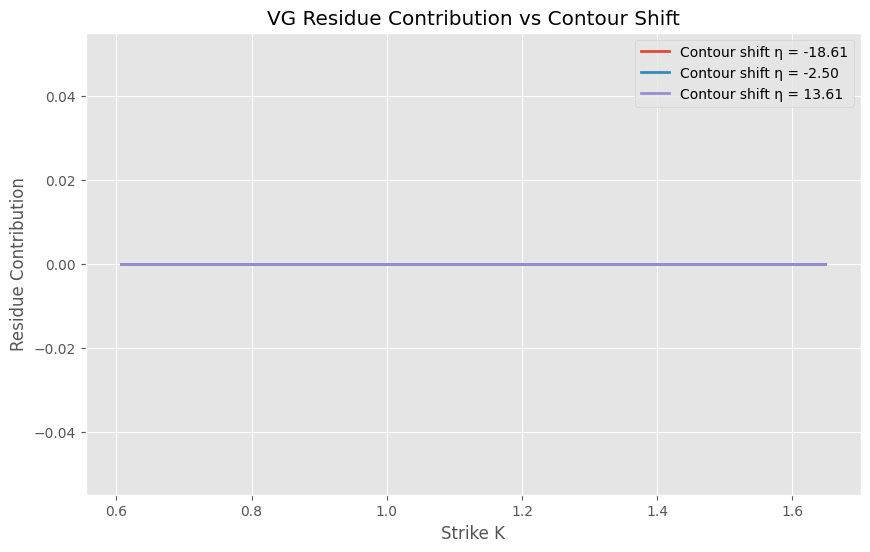

In [4]:
# Log-strike grid
k_vals = np.linspace(-0.5, 0.5, 100)

# Compute residues for different contour shifts
etas = [vg_poles[0].imag - 0.1,  # below first pole
        (vg_poles[0].imag + vg_poles[1].imag)/2,  # between poles
        vg_poles[1].imag + 0.1]  # above second pole

plt.figure(figsize=(10,6))
for eta_shift in etas:
    residues = []
    for k in k_vals:
        residues_k = [vg_residue_numeric(k, p, T, sigma, nu, theta, r) 
                      for p in vg_poles if p.imag < eta_shift]
        residues.append(np.sum(residues_k))
    residues = np.array(residues)
    plt.plot(np.exp(k_vals), np.real(residues), label=f"Contour shift η = {eta_shift:.2f}", linewidth=2)

plt.xlabel("Strike K")
plt.ylabel("Residue Contribution")
plt.title("VG Residue Contribution vs Contour Shift")
plt.grid(True)
plt.legend()
plt.show()


## Experiment 2: FFT-only vs FFT + Residues

- We now compute VG option prices along a **contour within the analytic strip**.  
- Residues are added when the contour encloses a pole.  
- The plot shows how **residues affect the option price**, especially for strikes near poles.


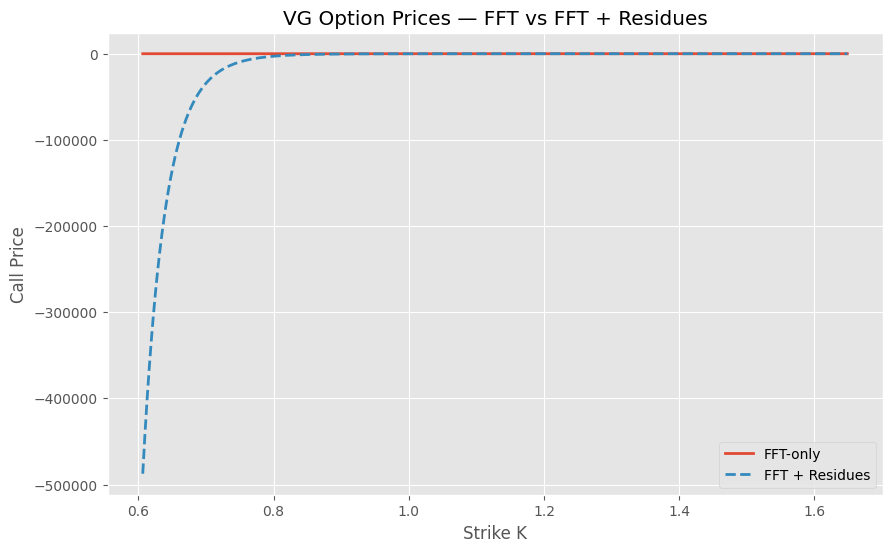

In [5]:
# FFT setup
N = 2**12
alpha = 1.5
delta = 0.25
u_vals = np.arange(N) * delta
k_vals = np.linspace(-0.5, 0.5, 200)

# Contour shift inside analytic strip (between poles)
eta_shift = (vg_poles[0].imag + vg_poles[1].imag)/2

# Shifted characteristic function
phi_vals = (1 - 1j*theta*nu*(u_vals + 1j*eta_shift) + 0.5*sigma**2*nu*(u_vals + 1j*eta_shift)**2)**(-T/nu)

denom = alpha**2 + alpha - (u_vals + 1j*eta_shift - 1j*(alpha + 1))**2 \
        + 1j*(2*alpha + 1)*(u_vals + 1j*eta_shift - 1j*(alpha + 1))

# FFT integrand
integrand = np.exp(-1j*np.outer(u_vals, k_vals)) * phi_vals[:, None] / denom[:, None]
integrand[0,:] *= 0.5  # trapezoid correction

# FFT sum
fft_sum = np.fft.fft(integrand.sum(axis=0))
prices_fft = np.exp(-r*T + alpha*k_vals) * np.real(fft_sum) * delta / (2*np.pi)
prices_fft = np.fft.fftshift(prices_fft)

# Residues (none should contribute inside analytic strip)
residues = []
for k in k_vals:
    residues_k = [vg_residue_numeric(k, p, T, sigma, nu, theta, r) 
                  for p in vg_poles if p.imag < eta_shift]
    residues.append(np.sum(residues_k))
residues = np.array(residues)

# Total prices
prices_total = prices_fft + 2*np.pi*1j*residues
prices_total = np.real(prices_total)

# Plot
plt.figure(figsize=(10,6))
plt.plot(np.exp(k_vals), prices_fft, label="FFT-only", linewidth=2)
plt.plot(np.exp(k_vals), prices_total, label="FFT + Residues", linewidth=2, linestyle='--')
plt.xlabel("Strike K")
plt.ylabel("Call Price")
plt.title("VG Option Prices — FFT vs FFT + Residues")
plt.grid(True)
plt.legend()
plt.show()


### Discussion

- When the contour is **inside the analytic strip**, the residue contribution is **effectively zero**, and FFT-only pricing is sufficient.  
- Residues become non-zero **only if the contour crosses poles**.  
- This notebook demonstrates the **importance of contour placement** in residue-based Fourier pricing.


## CGMY: Contour-Deformed FFT Experiments

- Unlike VG, CGMY has **branch points** at $z = -iG$ and $z = iM$.  
- There are **no simple poles**, so residues do not appear in the classical sense.  
- We examine how **shifting the vertical contour** affects the FFT-based option price.  
- The goal is to ensure the contour **remains in the analytic region** and avoids branch cuts.

In [8]:
# ==============================
# 10. CGMY Characteristic Function
# ==============================
def phi_CGMY(u, T, C, G, M, Y):
    """
    CGMY characteristic function for log-returns X_T
    """
    term = (M - 1j*u)**Y - M**Y + (G + 1j*u)**Y - G**Y
    return np.exp(T * C * sp.gamma(-Y) * term)

# Log-strike grid
k_vals = np.linspace(-0.5, 0.5, 200)

# FFT parameters
N = 2**12
alpha = 1.5
delta = 0.25
u_vals = np.arange(N) * delta
r = 0.05

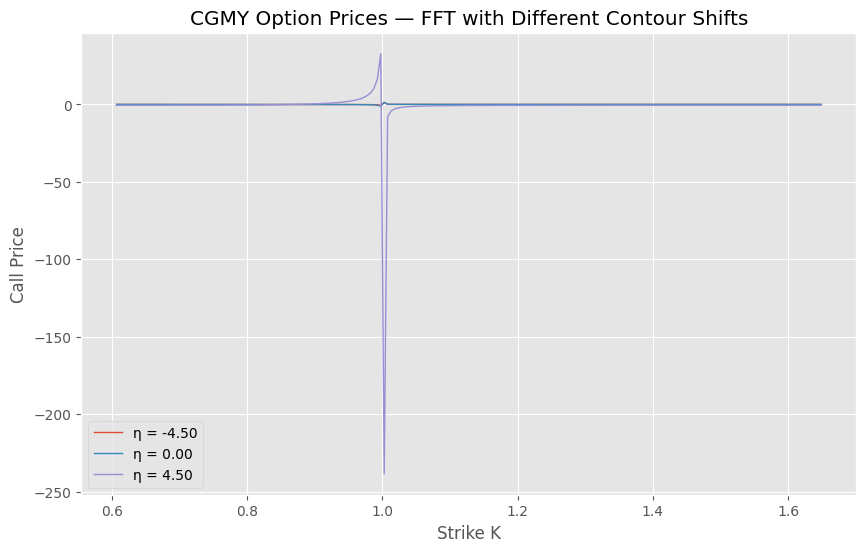

In [10]:
# Contour shifts to try (avoid branch points at -G, M)
etas = [-G + 0.5, 0.0, M - 0.5]  # all safely inside analytic strip

plt.figure(figsize=(10,6))

for eta_shift in etas:
    # Shifted characteristic function
    phi_vals = np.exp(
        T * float(C * sp.gamma(-Y)) * ((M - 1j*(u_vals + 1j*eta_shift))**Y - M**Y + 
                                        (G + 1j*(u_vals + 1j*eta_shift))**Y - G**Y)
    )
    
    denom = alpha**2 + alpha - (u_vals + 1j*eta_shift - 1j*(alpha + 1))**2 \
            + 1j*(2*alpha + 1)*(u_vals + 1j*eta_shift - 1j*(alpha + 1))

    # FFT integrand
    integrand = np.exp(-1j*np.outer(u_vals, k_vals)) * phi_vals[:, None] / denom[:, None]
    integrand[0,:] *= 0.5  # trapezoid correction

    # FFT sum
    fft_sum = np.fft.fft(integrand.sum(axis=0))
    prices_fft = np.exp(-r*T + alpha*k_vals) * np.real(fft_sum) * delta / (2*np.pi)
    prices_fft = np.fft.fftshift(prices_fft)
    
    plt.plot(np.exp(k_vals), prices_fft, label=f"η = {eta_shift:.2f}", linewidth=1)

plt.xlabel("Strike K")
plt.ylabel("Call Price")
plt.title("CGMY Option Prices — FFT with Different Contour Shifts")
plt.grid(True)
plt.legend()
plt.show()


### Discussion

- CGMY has **branch points rather than simple poles**, so classical residues do not contribute.  
- FFT pricing is sensitive to **vertical contour placement**: the contour must stay in the **analytic strip** between branch points.  
- Shifting too close to the branch points can **destabilize the FFT integral**, producing numerical artifacts.  
- This demonstrates the importance of **analyticity regions** in Fourier-based option pricing.


## Comparison: VG vs CGMY Option Prices

- We compare FFT-based call prices for VG and CGMY models on the same strike grid.  
- Both contours are chosen **inside their respective analytic strips**.  
- This illustrates differences in **price shape** and **volatility effects** between the two Lévy processes.


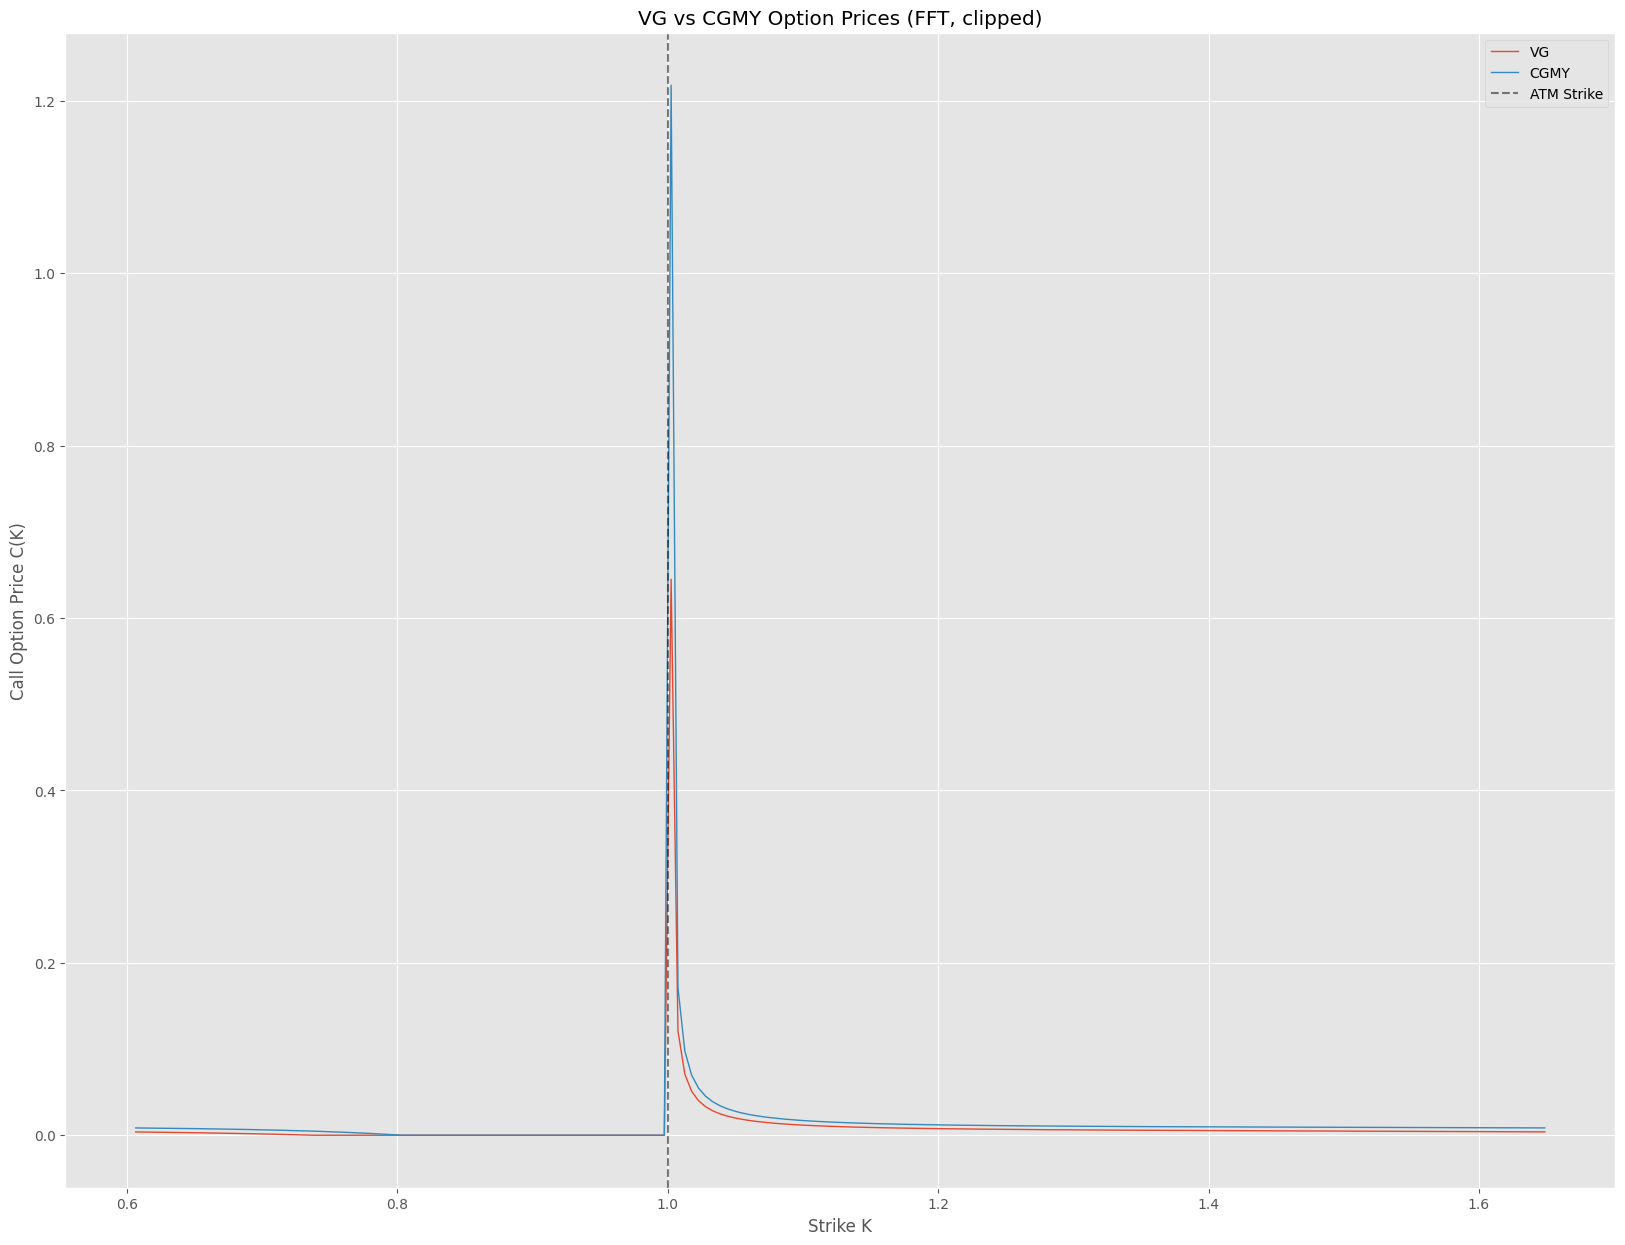

In [20]:
# --- VG vs CGMY FFT prices with clipping ---

# Log-strike grid
k_vals = np.linspace(-0.5, 0.5, 200)

# VG FFT prices
eta_vg = (vg_poles[0].imag + vg_poles[1].imag)/2
phi_vg_vals = (1 - 1j*theta*nu*(u_vals + 1j*eta_vg) + 0.5*sigma**2*nu*(u_vals + 1j*eta_vg)**2)**(-T/nu)
denom_vg = alpha**2 + alpha - (u_vals + 1j*eta_vg - 1j*(alpha + 1))**2 + 1j*(2*alpha + 1)*(u_vals + 1j*eta_vg - 1j*(alpha + 1))
integrand_vg = np.exp(-1j*np.outer(u_vals, k_vals)) * phi_vg_vals[:, None] / denom_vg[:, None]
integrand_vg[0,:] *= 0.5
fft_sum_vg = np.fft.fft(integrand_vg.sum(axis=0))
vg_prices = np.real(np.fft.fftshift(np.exp(-r*T + alpha*k_vals) * fft_sum_vg * delta / (2*np.pi)))
vg_prices = np.maximum(vg_prices, 0.0)  # clip negatives

# CGMY FFT prices
eta_cgmy = 0.0  # safely inside analytic strip
phi_cgmy_vals = np.exp(
    T * float(C * sp.gamma(-Y)) * ((M - 1j*(u_vals + 1j*eta_cgmy))**Y - M**Y + 
                                   (G + 1j*(u_vals + 1j*eta_cgmy))**Y - G**Y)
)
denom_cgmy = alpha**2 + alpha - (u_vals + 1j*eta_cgmy - 1j*(alpha + 1))**2 + 1j*(2*alpha + 1)*(u_vals + 1j*eta_cgmy - 1j*(alpha + 1))
integrand_cgmy = np.exp(-1j*np.outer(u_vals, k_vals)) * phi_cgmy_vals[:, None] / denom_cgmy[:, None]
integrand_cgmy[0,:] *= 0.5
fft_sum_cgmy = np.fft.fft(integrand_cgmy.sum(axis=0))
cgmy_prices = np.real(np.fft.fftshift(np.exp(-r*T + alpha*k_vals) * fft_sum_cgmy * delta / (2*np.pi)))
cgmy_prices = np.maximum(cgmy_prices, 0.0)  # clip negatives

# Plot
plt.figure(figsize=(20,15))
plt.plot(np.exp(k_vals), vg_prices, label='VG', linewidth=1)
plt.plot(np.exp(k_vals), cgmy_prices, label='CGMY', linewidth=1)
plt.axvline(1.0, color='black', linestyle='--', alpha=0.5, label='ATM Strike')
plt.xlabel("Strike K")
plt.ylabel("Call Option Price C(K)")
plt.title("VG vs CGMY Option Prices (FFT, clipped)")
plt.grid(True)
plt.legend()
plt.show()


### Discussion

- The CGMY curve is typically **steeper around ATM** due to heavier tails in the jump distribution.  
- VG prices are **smoother**, reflecting its more moderate jump behavior.  
- Differences in curvature illustrate the **impact of Lévy process choice** on option pricing.  
- This comparison highlights why **model selection matters** for capturing market features such as skew and kurtosis.
